In [1]:
import pandas as pd
import geopandas as gpd #geopandas for dataframes with spatial info
from shapely.geometry import Point
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt #for creating plots

import os 
import seaborn as sns #for styling the plots
import statsmodels.formula.api as smf
import warnings
import urllib.request
import zipfile
import matplotlib as mpl
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Change in listing descriptions

In [2]:
# this is the cleaned version, after exploratory analysis
listings = pd.read_csv('./PUI_Data/airbnb/clean_airbnb_listings.csv')

In [3]:
import nltk
from nltk.corpus import stopwords
import re
import string
from bs4 import BeautifulSoup
import gensim
from gensim import models
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
# remove descriptions that are NaN 
# filter desriptions for listings in 2020
testset = listings[listings.description.notnull()][(listings['year']==2020)]

#### 1.0 Building word2vec model

In [5]:
# tokenize the listings, append list of tokens for word2vec model
# numbers, html tags, punctuations, double spaces, stopwords are removed
ttokens=[]
stop_words = set(stopwords.words('english'))
for text in testset.description:
    text_nonum = re.sub(r'\d+', '', text)
    text_nohtml = BeautifulSoup(text_nonum, "lxml").text
    text_nodash = re.sub(r'-',' ',text_nohtml)
    text_nopunct = "".join([char.lower() for char in text_nodash if char not in string.punctuation]) 
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    ttokens.append([t for t in text_no_doublespace.split() if t not in stop_words]) # remove stopwords

In [6]:
# training word2vec model
model = gensim.models.Word2Vec(ttokens, min_count=1,size=100,workers=4)

In [7]:
# with the most_similar function we can explore broad themes in the listings
print(model.most_similar(positive=['coronavirus'],topn=20))
print(model.most_similar(positive=['mask']))
print(model.most_similar(positive=['frontline']))

[('pandemic', 0.8106306791305542), ('covid', 0.777254581451416), ('outbreak', 0.7183017134666443), ('precautions', 0.7053471803665161), ('crisis', 0.6980487108230591), ('virus', 0.6930223703384399), ('sanitizing', 0.6858267188072205), ('viral', 0.6810903549194336), ('cdc', 0.676338791847229), ('procedures', 0.6747583150863647), ('disinfect', 0.6682676076889038), ('updatemy', 0.6675398349761963), ('fight', 0.6520447731018066), ('prevention', 0.644681990146637), ('experts', 0.6384484767913818), ('wuhan', 0.631658673286438), ('results', 0.6301978826522827), ('guidelines', 0.6301625967025757), ('germs', 0.6300048828125), ('antibodies', 0.6186659932136536)]
[('masks', 0.7689292430877686), ('gloves', 0.7485462427139282), ('wearing', 0.6692668795585632), ('spray', 0.6331809759140015), ('clorox', 0.6329555511474609), ('lysol', 0.6314247846603394), ('toothbrushpaste', 0.6252113580703735), ('wear', 0.6176000237464905), ('slippers', 0.6089611053466797), ('dirty', 0.5994935035705566)]
[('rentdisco

In [8]:
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [9]:
def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word],topn=20)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 100 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal',
                ).set_size(12)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

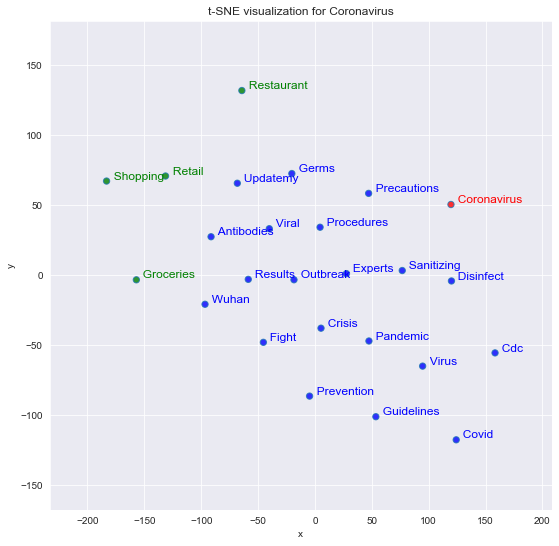

In [10]:
# t-sne plot for showing closely related words in 2 dimensions
tsnescatterplot(model, 'coronavirus', ['retail','groceries','shopping','restaurant']) 
# compared to four unrelated words

#### 1.0.1 Specific token frequency in each month of listings

In [29]:
# building df with monthly listing descriptions as tokens
mtokens = []
for month in range(9):
    monthlistings = listings[listings.description.notnull()][(listings['year']==2020) & (listings['month']==(month+1))]
    tokens = []
    
    for text in monthlistings.description:
        text_nonum = re.sub(r'\d+', '', text)
        text_nohtml = BeautifulSoup(text_nonum, "lxml").text
        text_nodash = re.sub(r'-',' ',text_nohtml)
        text_nopunct = "".join([char.lower() for char in text_nodash if char not in string.punctuation]) 
        text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
        tokens.append([t for t in text_no_doublespace.split() if t not in stop_words])
    
    tokens2 = []
    
    for bag in tokens:
        for word in bag:
            tokens2.append(word)
    
    mtokens.append(tokens2)

In [30]:
mlistings = pd.DataFrame(index=range(9),columns=['tokens'])
for i in range(9):
    mlistings.iloc[i,0] = mtokens[i]
mlistings

,tokens
0,"[urban, retreat, enjoy, sf, floor, brownstone,..."
1,"[urban, retreat, enjoy, sf, floor, brownstone,..."
2,"[lovely, spacious, sunny, br, apartment, th, f..."
3,"[lovely, spacious, sunny, br, apartment, th, f..."
4,"[lovely, spacious, sunny, br, apartment, th, f..."
5,"[lovely, spacious, sunny, br, apartment, th, f..."
6,"[lovely, spacious, sunny, br, apartment, th, f..."
7,"[enjoy, sf, top, floor, brownstone, w, wood, c..."
8,"[enjoy, sf, top, floor, brownstone, w, wood, c..."


In [32]:
# get list of words closely related to coronavirus
coronalist = [x[0] for x in model.most_similar(positive=['coronavirus'])]
coronalist

['pandemic',
 'covid',
 'outbreak',
 'precautions',
 'crisis',
 'virus',
 'sanitizing',
 'viral',
 'cdc',
 'procedures']

In [33]:
# get frequency of corona-similar tokens in each month of listings
coronafreq=[]
for tokens in mlistings.tokens:
    freq = 0
    for word in coronalist:
        freq += tokens.count(word)
    coronafreq.append(freq)
coronafreq

[7, 8, 135, 453, 619, 835, 967, 873, 900]

In [34]:
# append frequency
mlistings['coronavirus'] = coronafreq
mlistings

,tokens,coronavirus
0,"[urban, retreat, enjoy, sf, floor, brownstone,...",7
1,"[urban, retreat, enjoy, sf, floor, brownstone,...",8
2,"[lovely, spacious, sunny, br, apartment, th, f...",135
3,"[lovely, spacious, sunny, br, apartment, th, f...",453
4,"[lovely, spacious, sunny, br, apartment, th, f...",619
5,"[lovely, spacious, sunny, br, apartment, th, f...",835
6,"[lovely, spacious, sunny, br, apartment, th, f...",967
7,"[enjoy, sf, top, floor, brownstone, w, wood, c...",873
8,"[enjoy, sf, top, floor, brownstone, w, wood, c...",900


In [35]:
# do the same for 'mask' and 'frontline'
keywordlist = [x[0] for x in model.most_similar(positive=['mask'])]
tokenfreq=[]

for tokens in mlistings.tokens:
    freq = 0
    for word in keywordlist:
        freq += tokens.count(word)
    tokenfreq.append(freq)

mlistings['mask'] = tokenfreq

keywordlist = [x[0] for x in model.most_similar(positive=['frontline'])]
tokenfreq=[]

for tokens in mlistings.tokens:
    freq = 0
    for word in keywordlist:
        freq += tokens.count(word)
    tokenfreq.append(freq)

mlistings['frontline'] = tokenfreq

mlistings

,tokens,coronavirus,mask,frontline
0,"[urban, retreat, enjoy, sf, floor, brownstone,...",7,224,50
1,"[urban, retreat, enjoy, sf, floor, brownstone,...",8,223,47
2,"[lovely, spacious, sunny, br, apartment, th, f...",135,233,56
3,"[lovely, spacious, sunny, br, apartment, th, f...",453,333,92
4,"[lovely, spacious, sunny, br, apartment, th, f...",619,363,109
5,"[lovely, spacious, sunny, br, apartment, th, f...",835,403,88
6,"[lovely, spacious, sunny, br, apartment, th, f...",967,416,83
7,"[enjoy, sf, top, floor, brownstone, w, wood, c...",873,361,40
8,"[enjoy, sf, top, floor, brownstone, w, wood, c...",900,344,40


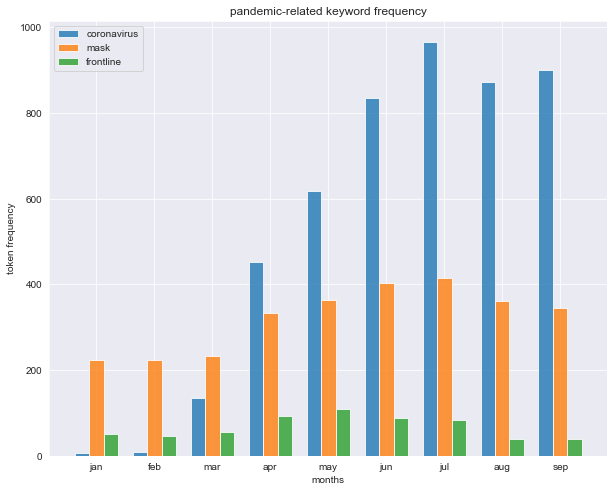

In [38]:
pos = list(range(9)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(pos, mlistings['coronavirus'],width,alpha=0.8)
plt.bar([p + width for p in pos], mlistings['mask'],width,alpha=0.8)
plt.bar([p + width*2 for p in pos], mlistings['frontline'],width,alpha=0.8)

ax.set_title('pandemic-related keyword frequency')
ax.set_ylabel('token frequency')b
ax.set_xlabel('months')
ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep'])
plt.legend(['coronavirus', 'mask', 'frontline'], loc='upper left')

plt.show()

#### 1.0.2 Does this listing contain keywords or not

In [41]:
keywordtest = testset[['id','description','month']]
keywordtest.head()

,id,description,month
0,2060,"Lovely, spacious, sunny 1 BR apartment in 6th ...",6
1,3831,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",6
2,5099,My large 1 bedroom apartment has a true New Yo...,6
3,5121,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,6
4,5136,We welcome you to stay in our lovely 2 br dupl...,6


In [42]:
def tokenize(text):
    text_nonum = re.sub(r'\d+', '', text)
    text_nohtml = BeautifulSoup(text_nonum, "lxml").text
    text_nodash = re.sub(r'-',' ',text_nohtml)
    text_nopunct = "".join([char.lower() for char in text_nodash if char not in string.punctuation]) 
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    tokens = [t for t in text_no_doublespace.split() if t not in stop_words]
    return tokens

In [47]:
keywordtest['tokens'] = keywordtest.description.apply(lambda x: tokenize(x))

In [48]:
keywordtest.head()

,id,description,month,tokens
0,2060,"Lovely, spacious, sunny 1 BR apartment in 6th ...",6,"[lovely, spacious, sunny, br, apartment, th, f..."
1,3831,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",6,"[enjoy, sf, top, floor, brownstone, w, wood, c..."
2,5099,My large 1 bedroom apartment has a true New Yo...,6,"[large, bedroom, apartment, true, new, york, c..."
3,5121,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,6,"[hello, everyone, thanks, visiting, bliss, art..."
4,5136,We welcome you to stay in our lovely 2 br dupl...,6,"[welcome, stay, lovely, br, duplex, south, slo..."


In [90]:
coronalist = [x[0] for x in model.most_similar(positive=['coronavirus'])]
masklist = [x[0] for x in model.most_similar(positive=['mask'])]
frontlinelist = [x[0] for x in model.most_similar(positive=['frontline'])]

In [86]:
def keywordcheck(keywordlist,tokens):
    check=0
    for word in keywordlist:
        if word in tokens:
            check=1
    return check

In [91]:
keywordtest['coronavirus'] = keywordtest.tokens.apply(lambda x: keywordcheck(coronalist,x))
keywordtest['mask'] = keywordtest.tokens.apply(lambda x: keywordcheck(masklist,x))
keywordtest['frontline'] = keywordtest.tokens.apply(lambda x: keywordcheck(frontlinelist,x))

In [92]:
keywordtest.describe()

,id,month,coronavirus,mask,frontline
count,3.712910e+05,371291.000000,371291.000000,371291.000000,371291.000000
mean,2.199874e+07,4.887654,0.009268,0.006181,0.001503
std,1.318577e+07,2.566168,0.095822,0.078377,0.038738
min,2.060000e+03,1.000000,0.000000,0.000000,0.000000
25%,1.007014e+07,3.000000,0.000000,0.000000,0.000000
50%,2.163540e+07,5.000000,0.000000,0.000000,0.000000
75%,3.415772e+07,7.000000,0.000000,0.000000,0.000000
max,4.532998e+07,9.000000,1.000000,1.000000,1.000000


In [95]:
mkeywordtest = keywordtest.groupby(['month']).agg({'coronavirus':'sum','mask':'sum','frontline':'sum','id':'count'}).rename(columns={'id':'listing_count'})
mkeywordtest

,coronavirus,mask,frontline,listing_count
month,,,,
1,6,208,45,43498
2,7,206,45,43045
3,81,216,54,42608
4,297,276,88,42111
5,441,279,96,42024
6,592,285,81,41294
7,691,292,77,40452
8,654,273,36,38493
9,672,260,36,37766


In [99]:
# normalise by listing_count
mkeywordtest['coronavirus_n'] = (mkeywordtest['coronavirus'] / mkeywordtest.listing_count)*100
mkeywordtest['mask_n'] = (mkeywordtest['mask'] / mkeywordtest.listing_count)*100
mkeywordtest['frontline_n'] = (mkeywordtest['frontline'] / mkeywordtest.listing_count)*100
mkeywordtest

,coronavirus,mask,frontline,listing_count,coronavirus_n,mask_n,frontline_n
month,,,,,,,
1,6,208,45,43498,0.013794,0.478183,0.103453
2,7,206,45,43045,0.016262,0.478569,0.104542
3,81,216,54,42608,0.190105,0.506947,0.126737
4,297,276,88,42111,0.705279,0.655411,0.208972
5,441,279,96,42024,1.049400,0.663906,0.228441
6,592,285,81,41294,1.433622,0.690173,0.196154
7,691,292,77,40452,1.708197,0.721843,0.190349
8,654,273,36,38493,1.699010,0.709220,0.093523
9,672,260,36,37766,1.779378,0.688450,0.095324


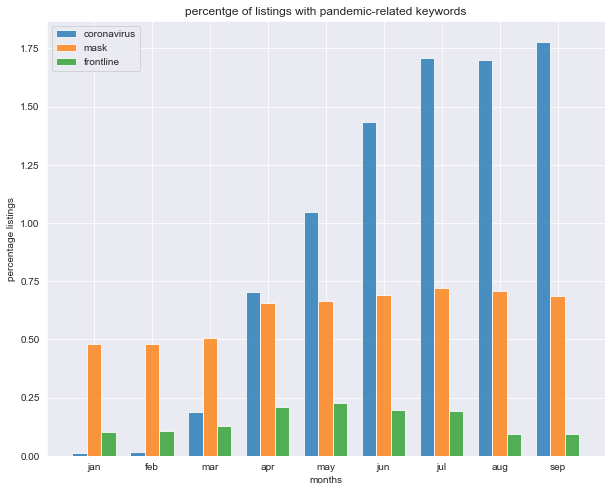

In [101]:
pos = list(range(9)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(pos, mkeywordtest['coronavirus_n'],width,alpha=0.8)
plt.bar([p + width for p in pos], mkeywordtest['mask_n'],width,alpha=0.8)
plt.bar([p + width*2 for p in pos], mkeywordtest['frontline_n'],width,alpha=0.8)

ax.set_title('percentge of listings with pandemic-related keywords')
ax.set_ylabel('percentage listings')
ax.set_xlabel('months')
ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep'])
plt.legend(['coronavirus', 'mask', 'frontline'], loc='upper left')

plt.show()

#### 1.1 Plotting token frequency

In [59]:
tokens=[]
for bag in ttokens:
    for word in bag:
        tokens.append(word)

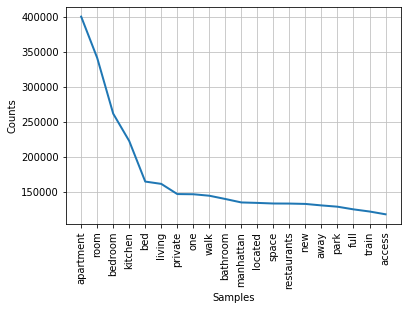

In [61]:
freq = nltk.FreqDist(tokens)
freq.plot(20, cumulative=False)

In [62]:
#frequency of tokens across listings
freqdf = pd.DataFrame(list(freq.items()), columns = ["Word","Frequency"])
freqdf.describe()

,Frequency
count,89385.000000
mean,248.673435
std,3690.268758
min,1.000000
25%,2.000000
50%,5.000000
75%,14.000000
max,400485.000000


#### 1.2 Generating wordcloud

In [65]:
text = " ".join(t for t in tokens)

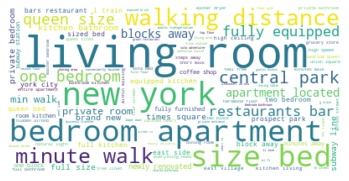

In [66]:
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()